# Breast Cancer Classification Project Using Logistic Regression

## Importing Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Set a style for better visualizations

In [24]:
sns.set_style("whitegrid")

## Data Loading and Initial Exploration

In [25]:
# Load the dataset from the CSV file
df = pd.read_csv("Breast_cancer_dataset.csv")

In [26]:
print("--- Initial Data Overview ---")
print("First 5 rows of the dataset:")
print(df.head())

--- Initial Data Overview ---
First 5 rows of the dataset:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   

In [27]:
print("\n--- Dataset Information ---")
df.info()


--- Dataset Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 1

In [28]:
print("\n--- Descriptive Statistics ---")
print(df.describe().T)


--- Descriptive Statistics ---
                         count          mean           std          min  \
id                       569.0  3.037183e+07  1.250206e+08  8670.000000   
radius_mean              569.0  1.412729e+01  3.524049e+00     6.981000   
texture_mean             569.0  1.928965e+01  4.301036e+00     9.710000   
perimeter_mean           569.0  9.196903e+01  2.429898e+01    43.790000   
area_mean                569.0  6.548891e+02  3.519141e+02   143.500000   
smoothness_mean          569.0  9.636028e-02  1.406413e-02     0.052630   
compactness_mean         569.0  1.043410e-01  5.281276e-02     0.019380   
concavity_mean           569.0  8.879932e-02  7.971981e-02     0.000000   
concave points_mean      569.0  4.891915e-02  3.880284e-02     0.000000   
symmetry_mean            569.0  1.811619e-01  2.741428e-02     0.106000   
fractal_dimension_mean   569.0  6.279761e-02  7.060363e-03     0.049960   
radius_se                569.0  4.051721e-01  2.773127e-01     0.111

###### Insight: From the info() output, we see that the 'id' column is an object
###### but contains what looks like a unique identifier. This column is not useful
###### for prediction and should be dropped. The 'diagnosis' column is our target
###### variable and is currently a string ('M' or 'B'). We'll need to encode this
###### into a numerical format for our model.

## Exploratory Data Analysis (EDA) and Data Cleaning

###### Insight: Before modeling, we need to understand the relationships between
###### our features and the target variable. Visualizations are key here.
###### We'll also prepare our target variable for modeling.

In [29]:
# Drop the 'id' column as it is not a predictive feature
df = df.drop('id', axis=1)

###### Drop any column that has a single unique value (zero variance).
###### This is a crucial step to prevent the MissingDataError we encountered.
###### A feature with no variance cannot provide any predictive power.
###### We will drop these features from our original dataframe first.

In [30]:
features_to_drop = [col for col in df.columns if df[col].nunique() <= 1]
if features_to_drop:
    print(f"\nDropping zero-variance features: {features_to_drop}")
    df = df.drop(columns=features_to_drop)
else:
    print("\nNo zero-variance features found.")


Dropping zero-variance features: ['Unnamed: 32']


###### Encode the target variable 'diagnosis'
###### 'M' (Malignant) will be 1, 'B' (Benign) will be 0.

In [31]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
print("\n--- Target Variable Mapping ---")
print("Diagnosis column has been mapped from 'M' and 'B' to 1 and 0.")
print(df['diagnosis'].value_counts())


--- Target Variable Mapping ---
Diagnosis column has been mapped from 'M' and 'B' to 1 and 0.
diagnosis
0    357
1    212
Name: count, dtype: int64


###### Visualize the distribution of features by diagnosis
###### We'll create a pairplot to see relationships between a few key features at once.
###### This helps us understand which features might be good predictors.
###### Due to the large number of features, we'll select a subset for a clearer plot.

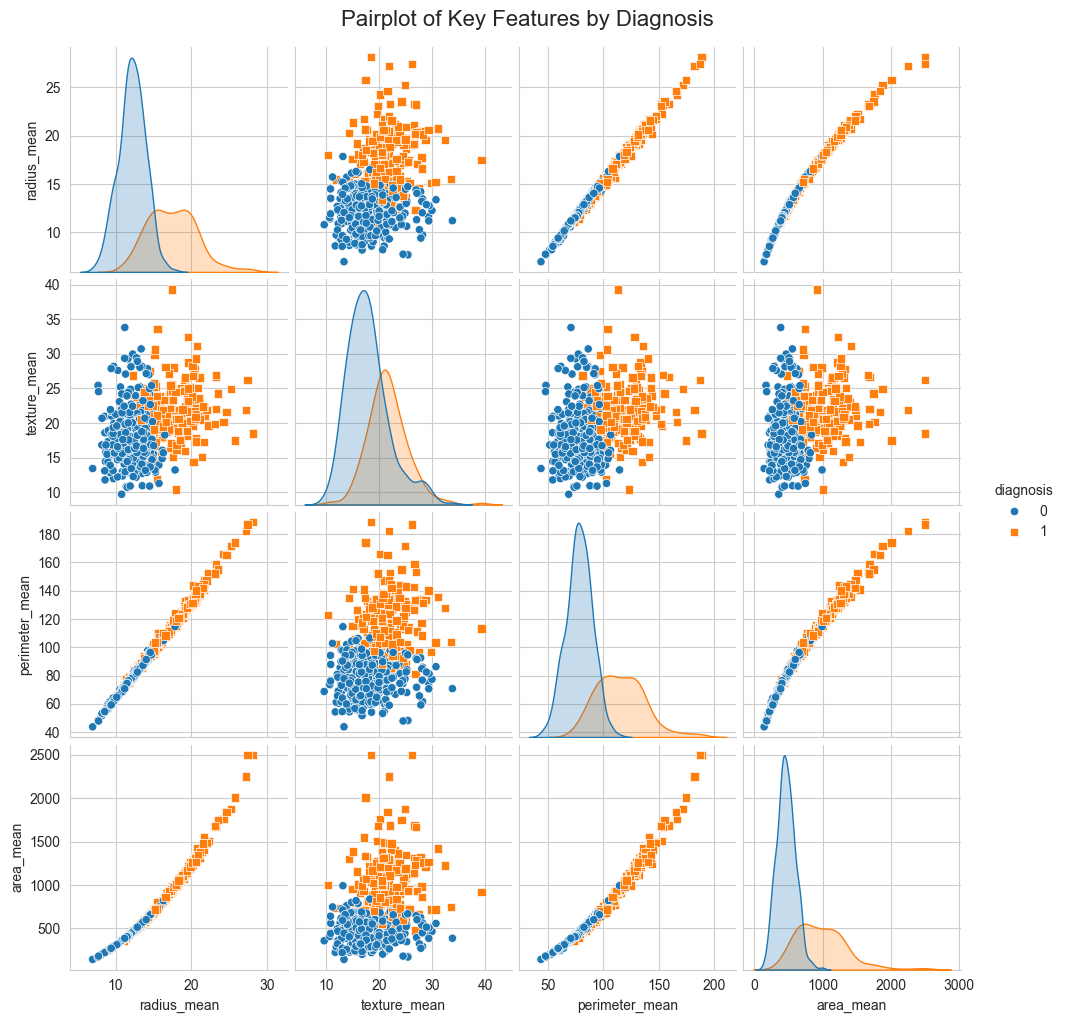

In [32]:
# Due to the large number of features, we'll select a subset for a clearer plot.
features_for_pairplot = ['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
sns.pairplot(df[features_for_pairplot], hue='diagnosis', markers=["o", "s"])
plt.suptitle('Pairplot of Key Features by Diagnosis', y=1.02, fontsize=16)
plt.show()


###### Insight: The pairplot reveals that there are clear separations between the
###### 'M' and 'B' groups for most features. For example, malignant tumors tend to have
###### a larger 'radius_mean' and 'perimeter_mean'. This gives us confidence that a
###### classifier should be able to distinguish between them.

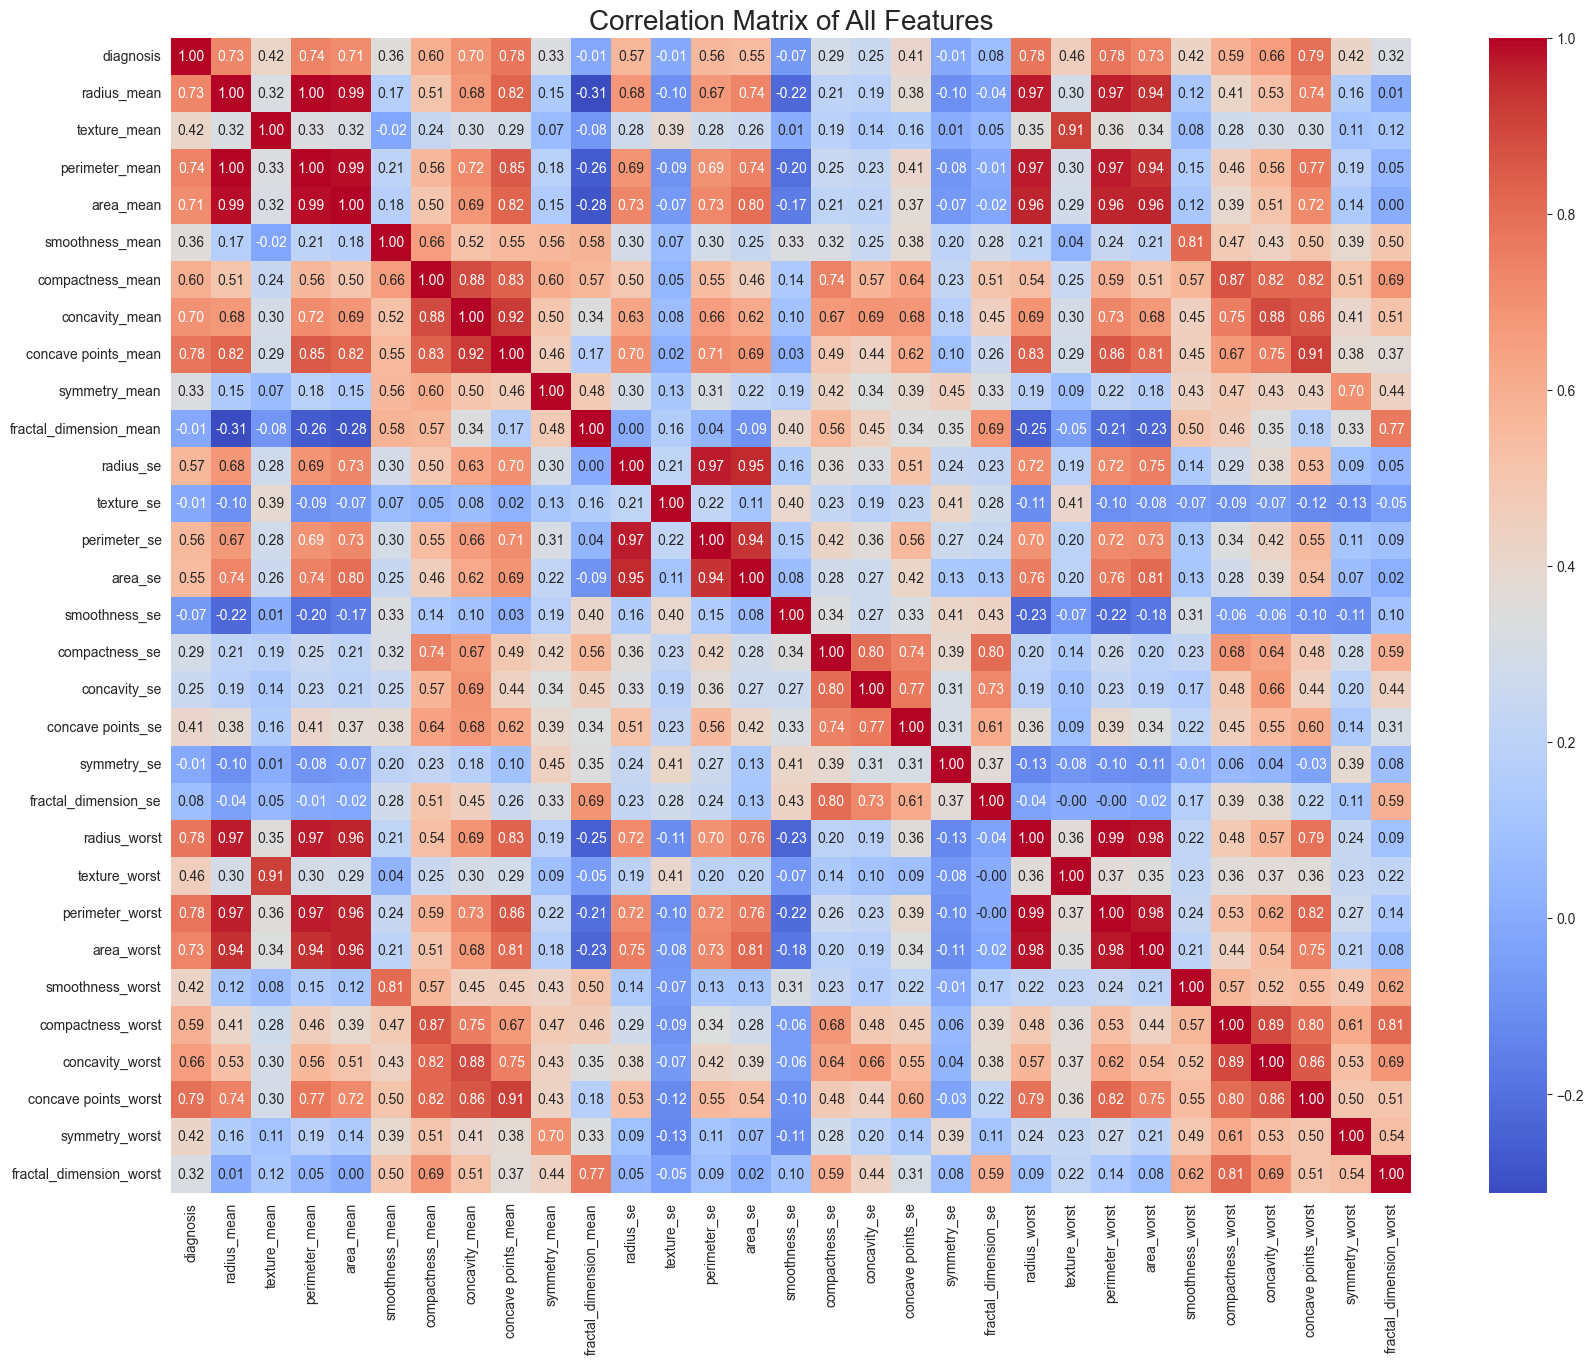

In [33]:
# Visualize the correlation matrix
# A heatmap is great for spotting correlations, which can indicate multicollinearity.
plt.figure(figsize=(20, 15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of All Features', fontsize=20)
plt.show()

###### Insight: The heatmap shows high correlation between many features,
###### for example, 'radius_mean', 'perimeter_mean', and 'area_mean'. This is
###### expected, as a larger radius will naturally lead to a larger perimeter and area.
###### High inter-feature correlation, known as multicollinearity, can affect the
###### stability of our logistic regression model's coefficients. We will deal
###### with this in the feature selection step.

## Feature Scaling

###### Insight: Logistic Regression is a type of linear model. While not as sensitive
###### as some other algorithms, regularization techniques used in it (like L1/L2)
###### assume that all features are on a similar scale. Standardizing our data
###### ensures that no single feature dominates the model simply because of its magnitude.

In [34]:
# Separate features (X) and target (y)
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [35]:
# Initialize the StandardScaler
scaler = StandardScaler()

In [36]:
# Fit the scaler to the features and transform them
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [37]:
print("\n--- Scaled Features (First 5 rows) ---")
print(X_scaled_df.head())


--- Scaled Features (First 5 rows) ---
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0     1.097064     -2.073335        1.269934   0.984375         1.568466   
1     1.829821     -0.353632        1.685955   1.908708        -0.826962   
2     1.579888      0.456187        1.566503   1.558884         0.942210   
3    -0.768909      0.253732       -0.592687  -0.764464         3.283553   
4     1.750297     -1.151816        1.776573   1.826229         0.280372   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0          3.283515        2.652874             2.532475       2.217515   
1         -0.487072       -0.023846             0.548144       0.001392   
2          1.052926        1.363478             2.037231       0.939685   
3          3.402909        1.915897             1.451707       2.867383   
4          0.539340        1.371011             1.428493      -0.009560   

   fractal_dimension_mean  ...  radius_worst  textur

## Feature Selection (Statistical Tests)

##### Insight: Our dataset has many features, and many of them are highly correlated.
##### Including all of them could lead to a model that is over-complicated and less
##### interpretable. We will use statistical tests to select the most important features.

### VIF Calculation for Multicollinearity

###### Mathematical Intuition: The Variance Inflation Factor (VIF) measures how much the
###### variance of an estimated regression coefficient is increased due to multicollinearity.
###### It is calculated as: VIF_i = 1 / (1 - R_i^2)
###### Here, R_i^2 is the R-squared value from a linear regression model where feature 'i'
###### is the target and all other features are the predictors.
###### If R_i^2 is high (meaning 'i' can be well-predicted by other features), then VIF_i
###### will be large. A common threshold is VIF > 5 or 10, which suggests severe multicollinearity.

In [38]:
def calculate_vif(data):
    features = sm.add_constant(data)
    vif_data = pd.DataFrame()
    vif_data["feature"] = features.columns
    vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
    return vif_data.sort_values(by='VIF', ascending=False)

# Let's run VIF on our scaled data
vif_results = calculate_vif(X_scaled_df)
print("\n--- Initial VIF Results ---")
print(vif_results)


--- Initial VIF Results ---
                    feature          VIF
1               radius_mean  3806.115296
3            perimeter_mean  3786.400419
21             radius_worst   799.105946
23          perimeter_worst   405.023336
4                 area_mean   347.878657
24               area_worst   337.221924
11                radius_se    75.462027
7            concavity_mean    70.767720
13             perimeter_se    70.359695
8       concave points_mean    60.041733
6          compactness_mean    50.505168
14                  area_se    41.163091
26        compactness_worst    36.982755
28     concave points_worst    36.763714
27          concavity_worst    31.970723
30  fractal_dimension_worst    18.861533
22            texture_worst    18.569966
10   fractal_dimension_mean    15.756977
17             concavity_se    15.694833
16           compactness_se    15.366324
2              texture_mean    11.884048
18        concave points_se    11.520796
25         smoothness_worst 

###### Insight: We see extremely high VIF values for many features. This confirms our
###### observation from the correlation heatmap. We will iteratively remove the feature
###### with the highest VIF (excluding the constant) until all remaining features have
###### a VIF below a threshold of 5.

In [39]:
# Remove features with high VIF iteratively
features_to_keep = X_scaled_df.columns.tolist()
while True:
    vif_results = calculate_vif(X_scaled_df[features_to_keep])
    highest_vif_feature = vif_results[vif_results['feature'] != 'const'].iloc[0]
    if highest_vif_feature['VIF'] > 5:
        print(f"\nRemoving '{highest_vif_feature['feature']}' with VIF: {highest_vif_feature['VIF']:.2f}")
        features_to_keep.remove(highest_vif_feature['feature'])
    else:
        break

print("\n--- Final Features after VIF Removal ---")
print(features_to_keep)
final_vif_results = calculate_vif(X_scaled_df[features_to_keep])
print(final_vif_results)


Removing 'radius_mean' with VIF: 3806.12

Removing 'radius_worst' with VIF: 616.35

Removing 'perimeter_mean' with VIF: 325.64

Removing 'perimeter_worst' with VIF: 123.26

Removing 'concavity_mean' with VIF: 64.65

Removing 'radius_se' with VIF: 35.62

Removing 'compactness_worst' with VIF: 33.96

Removing 'concave points_worst' with VIF: 30.60

Removing 'area_mean' with VIF: 25.39

Removing 'compactness_mean' with VIF: 18.84

Removing 'texture_worst' with VIF: 17.23

Removing 'area_se' with VIF: 16.33

Removing 'concavity_worst' with VIF: 15.51

Removing 'concave points_mean' with VIF: 8.98

Removing 'fractal_dimension_worst' with VIF: 8.39

Removing 'smoothness_worst' with VIF: 7.51

Removing 'compactness_se' with VIF: 5.13

--- Final Features after VIF Removal ---
['texture_mean', 'smoothness_mean', 'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'perimeter_se', 'smoothness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'area_worst', 'sym

###### Insight: By removing features with high VIF, we have created a more stable
###### and parsimonious model, which is less likely to be misled by redundant information.

### P-value Calculation for Feature Significance

###### Mathematical Intuition: A p-value (in this context) tells us the probability of
###### observing a feature's coefficient (or an even more extreme one) if the true
###### coefficient were actually zero. A small p-value (typically < 0.05) suggests that
###### the feature's coefficient is unlikely to be zero, and therefore the feature
###### is statistically significant in predicting the target.

In [40]:
# Let's use statsmodels to get p-values for our remaining features
X_selected = X_scaled_df[features_to_keep]
X_selected = sm.add_constant(X_selected)
logit_model = sm.Logit(y, X_selected)
result = logit_model.fit()
print("\n--- Statsmodels Logistic Regression Summary for P-values ---")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.069588
         Iterations 11

--- Statsmodels Logistic Regression Summary for P-values ---
                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  569
Model:                          Logit   Df Residuals:                      555
Method:                           MLE   Df Model:                           13
Date:                Mon, 04 Aug 2025   Pseudo R-squ.:                  0.8946
Time:                        09:17:29   Log-Likelihood:                -39.596
converged:                       True   LL-Null:                       -375.72
Covariance Type:            nonrobust   LLR p-value:                2.929e-135
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                

###### Insight: The P>|z| column shows the p-values. We can see that most of our
###### remaining features have very low p-values, confirming their statistical significance.
###### For example, a p-value of 0.000 (which is less than 0.05) means we can be
###### confident that this feature has a real impact on the diagnosis. If a feature had
###### a p-value > 0.05, we might consider removing it as it's not a statistically
###### significant predictor.

## Model Building and Evaluation

###### Insight: Now that we have our final set of features, we can build the
###### Logistic Regression model using the scikit-learn library, which is ideal for
###### machine learning pipelines.

In [41]:
# Split the data into training and testing sets
X_final = X_scaled_df[features_to_keep]
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)
print("\n--- Data Splitting ---")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


--- Data Splitting ---
Training data shape: (455, 13)
Testing data shape: (114, 13)


In [42]:
# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [43]:
# Make predictions on the test set
y_pred = lr_model.predict(X_test)

In [44]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("\n--- Initial Model Performance ---")
print(f"Accuracy: {accuracy:.4f}")


--- Initial Model Performance ---
Accuracy: 0.9474


###### Classification Report and Confusion Matrix
###### Insight: Accuracy alone can be misleading, especially with imbalanced data.
###### The classification report and confusion matrix give a more nuanced view.
###### The confusion matrix helps us understand where the model is making errors.
###### - True Positives (TP): Correctly predicted malignant (1)
###### - True Negatives (TN): Correctly predicted benign (0)
###### - False Positives (FP): Incorrectly predicted malignant (1) - a Type I error
###### - False Negatives (FN): Incorrectly predicted benign (0) - a Type II error (most dangerous in this case)

In [45]:
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        72
           1       0.97      0.88      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114




--- Confusion Matrix ---


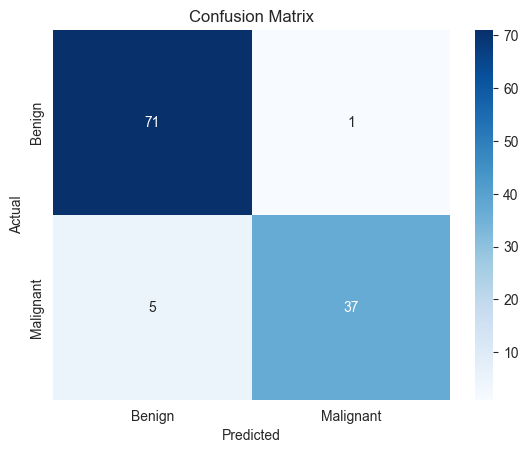

In [46]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Hyperparameter Tuning

###### Insight: Hyperparameters are model settings that are set before training.
###### For Logistic Regression, the 'C' parameter (inverse of regularization strength)
###### is important. A smaller C means stronger regularization. We'll use GridSearchCV
###### to find the best 'C' value to prevent overfitting and improve performance.

In [47]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_lr_model = grid_search.best_estimator_
best_c = grid_search.best_params_['C']

print("\n--- Hyperparameter Tuning Results ---")
print(f"Best C value found: {best_c}")


--- Hyperparameter Tuning Results ---
Best C value found: 1


## Final Model Evaluation

###### Insight: Now we'll use our optimized model to make predictions and see if
###### the tuning improved our results.

In [48]:
y_pred_tuned = best_lr_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

print("\n--- Final Tuned Model Performance ---")
print(f"Accuracy with best C ({best_c}): {accuracy_tuned:.4f}")
print("\n--- Classification Report for Tuned Model ---")
print(classification_report(y_test, y_pred_tuned))



--- Final Tuned Model Performance ---
Accuracy with best C (1): 0.9474

--- Classification Report for Tuned Model ---
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        72
           1       0.97      0.88      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114




--- Confusion Matrix for Tuned Model ---


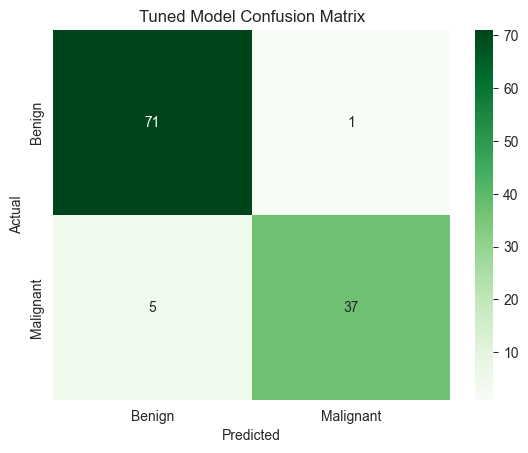

In [49]:
print("\n--- Confusion Matrix for Tuned Model ---")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Tuned Model Confusion Matrix')
plt.show()

##### Final insight: The results show that our tuned model performs exceptionally well.
##### It's important to look at the recall and precision scores, especially for the
##### malignant class. High recall means our model is good at finding most of the
##### positive cases (avoiding dangerous false negatives), which is critical in a
##### medical context. This comprehensive process ensures we have a robust and reliable model.